In [1]:
%matplotlib inline

In [1]:
import numpy as np
from numpy import exp, log, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.optimize import fminbound, fmin
import networkx as nx
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [69]:
# Coloring BP on ER graph
def BP_coloring(G, beta, q, init='perturb', schedule='random', damp=1, T=1000, abs_tol=1e-4, report=False):
    theta = 1 - exp(-beta)
    def BP_update(chi, schedule):
        chi_new, diff = chi.copy(), 0
        if schedule == 'parallel':
            for j in G.nodes():
                full_prod = np.ones(q)
                for k in adj_list[j]:
                    full_prod *= 1 - theta * chi[(k, j)]
                for i in adj_list[j]:
                    chi_new[(j, i)] = full_prod / ( 1 - theta * chi[(i, j)] )
                    chi_new[(j, i)] /= chi_new[(j, i)].sum()
                    chi_new[(j, i)] = (1-damp) * chi[(j, i)] + damp * chi_new[(j, i)]
                    diff += abs(chi_new[(j, i)] - chi[(j, i)]).sum()
        elif schedule == 'random':
            perm = list(G.nodes())
            np.random.shuffle(perm)
            for j in perm:
                full_prod = np.ones(q)
                for k in adj_list[j]:
                    full_prod *= 1 - theta * chi_new[(k, j)]
                for i in adj_list[j]:
                    chi_new[(j, i)] = full_prod / ( 1 - theta * chi_new[(i, j)] )
                    chi_new[(j, i)] /= chi_new[(j, i)].sum()
                    chi_new[(j, i)] = (1-damp) * chi[(j, i)] + damp * chi_new[(j, i)]
                    diff += abs(chi_new[(j, i)] - chi[(j, i)]).sum()
        return chi_new, diff / (2*q*len(G.edges()))
    def compute_f_Bethe(chi):
        f = 0
        for i in G.nodes():
            full_prod = np.ones(q)
            for k in adj_list[i]:
                full_prod *= 1 - theta * chi[(k, i)]
            f += log(full_prod.sum())
        for i, j in G.edges():
            f -= log( 1 - theta * (chi[(i,j)] * chi[(j,i)]).sum() )
        return f / len(G.nodes())
        
    # Initialize BP messages randomly
    adj_list, chi, f_Bethe = [list(v.keys()) for k, v in sorted(G.adjacency())], {}, np.array([])
    for i, l in enumerate(adj_list):
        for j in l:
            if init == 'perturb':
                epsilon=0.1
                temp = 1 / q + np.random.uniform(low=-epsilon, high=epsilon, size=q) / q
                chi[(i,j)] = temp / temp.sum()
            elif init == 'first-color':
                chi[(i,j)] = np.array([1] + [0]*(q-1))
            elif init == 'random':
                temp = np.random.uniform(low=0, high=1, size=q)
                chi[(i,j)] = temp / temp.sum()
    for t in range(1,T+1):   
        chi, diff = BP_update(chi, schedule)
        f_Bethe = np.append(f_Bethe, compute_f_Bethe(chi))
        if report and t % report == 0:
            print('iteration {0}, f_Bethe = {1}'.format(t, f_Bethe[-4:]))
        if diff < abs_tol:
            if report:
                print('BP converge in {0} iteration'.format(t))
            break
    return f_Bethe, chi, t

In [108]:
# Problem 1 (b), different BP update schedule
N, beta, q, c = 1000, 2, 3, 5
G = nx.erdos_renyi_graph(N, c/(N-1))
f_Bethe1, BP_msg1, t1 = BP_coloring(G, beta=beta, q=q, schedule='parallel', report=100)
f_Bethe2, BP_msg2, t2 = BP_coloring(G, beta=beta, q=q, schedule='random', report=100)

iteration 100, f_Bethe = [ 1.51308036  2.73361181  1.51276669  2.7342615 ]
iteration 200, f_Bethe = [ 1.50254097  2.75565917  1.50241171  2.75593238]
iteration 300, f_Bethe = [ 1.498273    2.76471749  1.4982216   2.76482704]
iteration 400, f_Bethe = [ 1.49658777  2.76831533  1.49656763  2.76835841]
iteration 500, f_Bethe = [ 1.49592904  2.76972496  1.49592118  2.76974177]
iteration 600, f_Bethe = [ 1.49567256  2.77027429  1.49566951  2.77028083]
iteration 700, f_Bethe = [ 1.49557286  2.77048791  1.49557167  2.77049045]
iteration 800, f_Bethe = [ 1.49553413  2.77057091  1.49553367  2.7705719 ]
iteration 900, f_Bethe = [ 1.49551908  2.77060316  1.4955189   2.77060354]
iteration 1000, f_Bethe = [ 1.49551324  2.77061568  1.49551317  2.77061583]
BP converge in 24 iteration


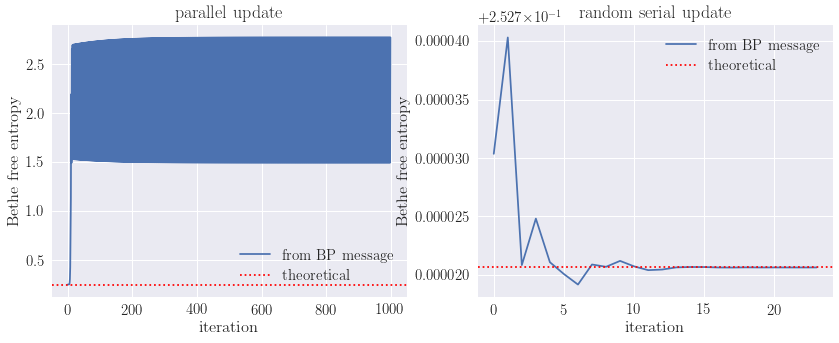

In [109]:
f_theoretical = log(q) + len(G.edges())/len(G.nodes()) * log( 1-(1-exp(-beta))/q )
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(f_Bethe1, label='from BP message')
plt.axhline(y = f_theoretical, color='red', linestyle=':', label='theoretical')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Bethe free entropy')
plt.title('parallel update')
plt.subplot(1,2,2)
plt.plot(f_Bethe2, label='from BP message')
plt.axhline(y = f_theoretical, color='red', linestyle=':', label='theoretical')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Bethe free entropy')
plt.title('random serial update')
plt.savefig('hw3_1(b).pdf', bbox_inches='tight')

In [ ]:
# %load coloring_ER_simul.py
import numpy as np
from numpy import exp, log, sqrt, tanh
import networkx as nx
from collections import defaultdict
import multiprocessing as mp

def BP_coloring(G, beta, q, init='perturb', schedule='random', damp=1, T=1000, abs_tol=1e-4, report=False):
    theta = 1 - exp(-beta)
    def BP_update(chi, schedule):
        chi_new, diff = chi.copy(), 0
        if schedule == 'parallel':
            for j in G.nodes():
                full_prod = np.ones(q)
                for k in adj_list[j]:
                    full_prod *= 1 - theta * chi[(k, j)]
                for i in adj_list[j]:
                    chi_new[(j, i)] = full_prod / ( 1 - theta * chi[(i, j)] )
                    chi_new[(j, i)] /= chi_new[(j, i)].sum()
                    chi_new[(j, i)] = (1-damp) * chi[(j, i)] + damp * chi_new[(j, i)]
                    diff += abs(chi_new[(j, i)] - chi[(j, i)]).sum()
        elif schedule == 'random':
            perm = list(G.nodes())
            np.random.shuffle(perm)
            for j in perm:
                full_prod = np.ones(q)
                for k in adj_list[j]:
                    full_prod *= 1 - theta * chi_new[(k, j)]
                for i in adj_list[j]:
                    chi_new[(j, i)] = full_prod / ( 1 - theta * chi_new[(i, j)] )
                    chi_new[(j, i)] /= chi_new[(j, i)].sum()
                    chi_new[(j, i)] = (1-damp) * chi[(j, i)] + damp * chi_new[(j, i)]
                    diff += abs(chi_new[(j, i)] - chi[(j, i)]).sum()
        return chi_new, diff / (2*q*len(G.edges()))
    def compute_f_Bethe(chi):
        f = 0
        for i in G.nodes():
            full_prod = np.ones(q)
            for k in adj_list[i]:
                full_prod *= 1 - theta * chi[(k, i)]
            f += log(full_prod.sum())
        for i, j in G.edges():
            f -= log( 1 - theta * (chi[(i,j)] * chi[(j,i)]).sum() )
        return f / len(G.nodes())
        
    # Initialize BP messages randomly
    adj_list, chi, f_Bethe = [list(v.keys()) for k, v in sorted(G.adjacency())], {}, np.array([])
    for i, l in enumerate(adj_list):
        for j in l:
            if init == 'perturb':
                epsilon=0.1
                temp = 1 / q + np.random.uniform(low=-epsilon, high=epsilon, size=q) / q
                chi[(i,j)] = temp / temp.sum()
            elif init == 'first-color':
                chi[(i,j)] = np.array([1] + [0]*(q-1))
            elif init == 'random':
                temp = np.random.uniform(low=0, high=1, size=q)
                chi[(i,j)] = temp / temp.sum()
    for t in range(1,T+1):   
        chi, diff = BP_update(chi, schedule)
        f_Bethe = np.append(f_Bethe, compute_f_Bethe(chi))
        if report and t % report == 0:
            print('iteration {0}, f_Bethe = {1}'.format(t, f_Bethe[-4:]))
        if diff < abs_tol:
            if report:
                print('BP converge in {0} iteration'.format(t))
            break
    return f_Bethe, chi, t

if __name__ == "__main__":
    result = defaultdict(list)
    try:
        data = np.load('coloring_ER_simul.npz')
        for k, v in data.items():
            result[k] = v
    except:
        pass
    beta, q, trial, max_iter = 2, 3, 8, int(1e4)
    c = np.linspace(0.1, 10, 100)

    def single_case(x):
        i, N, cc = x
        G = nx.erdos_renyi_graph(N, cc/(N-1))
        f_Bethe, BP_msg, tt = BP_coloring(G, beta=beta, q=q, T=max_iter, report=False)
        print('trial {0} finished in {1} iterations'.format(i, tt))
        return tt
    pool = mp.Pool(trial)

    for N in [50, 100, 200, 500, 1000, 2000]:
        t = np.nan * np.ones((c.size, trial)) if result.get('N={}'.format(N)) is None else result['N={}'.format(N)]
        for i, cc in enumerate(c):
            if np.any(np.isnan(t[i])):
                print('\n'.join(['#'*80, 'c = {0}, N = {1}'.format(cc, N), '#'*80]))
                t[i] = pool.map(single_case, [(j, N, cc) for j in range(1, trial+1)])
                result['N={0}'.format(N)] = t
                print(i, cc, t[i].tolist())
                np.savez('coloring_ER_simul.npz', **result)
                if np.median(t[i]) == max_iter:
                    break

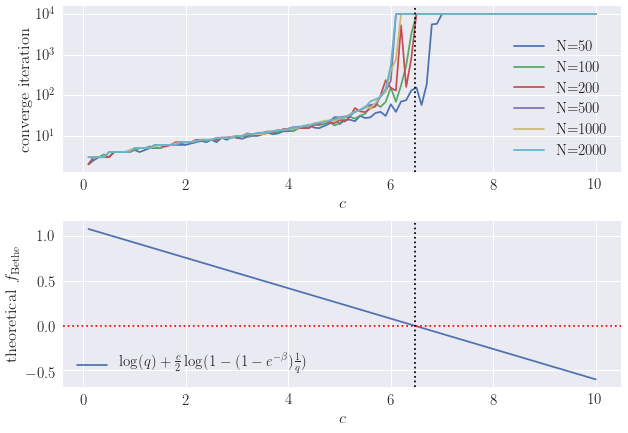

In [32]:
res = np.load('coloring_ER_simul.npz')
c = np.linspace(0.1, 10, 100)
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
# for N in [2000]:
for N in [50, 100, 200, 500, 1000, 2000]:
    try:
        t = res['N={}'.format(N)]
        t[np.isnan(t)] = 1e4
        t = np.median(t, axis=1)
#         plt.plot(c, t, label='N={}'.format(N))
        plt.semilogy(c, t, label='N={}'.format(N))
    except:
        pass
plt.axvline(x = 6.4626, color='black', linestyle=':')
plt.legend()
plt.xlabel(r'$c$')
plt.ylabel('converge iteration')
# plt.xlim((0, 7))
plt.subplot(2,1,2)
plt.plot(c, log(q) + c/2 * log( 1-(1-exp(-beta))/q ), label=r'$\log(q) + \frac{c}{2} \log (1 - (1-e^{-\beta}) \frac{1}{q})$')
plt.axhline(y = 0, color='red', linestyle=':')
plt.axvline(x = 6.4626, color='black', linestyle=':')
plt.legend()
plt.xlabel(r'$c$')
plt.ylabel(r'theoretical $ f_{\mathrm{Bethe}} $')
# plt.xlim((0, 7))
plt.subplots_adjust(hspace=0.3)
plt.savefig('hw3_1(c).pdf', bbox_inches='tight')

In [19]:
# Problem 1 (d), different initialization
N, beta, q, c = 1000, 2, 3, 5
G = nx.erdos_renyi_graph(N, c/(N-1))
f_Bethe1, BP_msg1, t1 = BP_coloring(G, beta=beta, q=q, init='perturb', report=100)
f_Bethe2, BP_msg2, t2 = BP_coloring(G, beta=beta, q=q, init='random', report=100)
f_Bethe3, BP_msg3, t3 = BP_coloring(G, beta=beta, q=q, init='first-color', report=100)

BP converge in 28 iteration
BP converge in 40 iteration
BP converge in 41 iteration


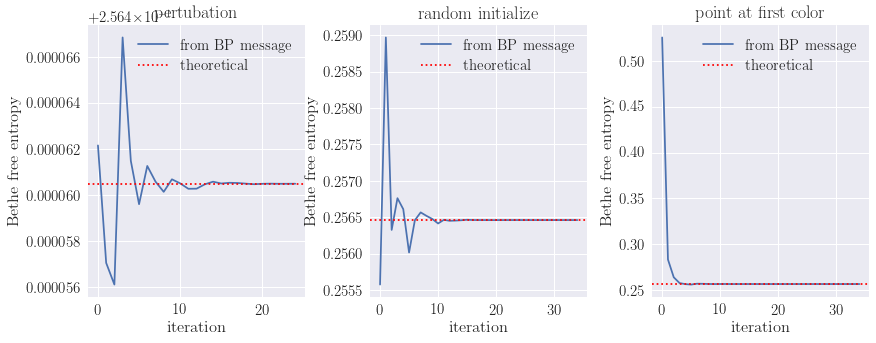

In [193]:
f_theoretical = log(q) + len(G.edges())/len(G.nodes()) * log( 1-(1-exp(-beta))/q )
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(f_Bethe1, label='from BP message')
plt.axhline(y = f_theoretical, color='red', linestyle=':', label='theoretical')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Bethe free entropy')
plt.title('pertubation')
plt.subplot(1,3,2)
plt.plot(f_Bethe2, label='from BP message')
plt.axhline(y = f_theoretical, color='red', linestyle=':', label='theoretical')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Bethe free entropy')
plt.title('random initialize')
plt.subplot(1,3,3)
plt.plot(f_Bethe3, label='from BP message')
plt.axhline(y = f_theoretical, color='red', linestyle=':', label='theoretical')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Bethe free entropy')
plt.title('point at first color')
plt.subplots_adjust(wspace=0.3)
plt.savefig('hw3_1(d).pdf', bbox_inches='tight')

In [3]:
# Problem 3 (b)
from scipy.integrate import quad
from scipy.optimize import fsolve
def f(m, beta, Delta):
    def integrand(h):
        return tanh(beta*(h+m)) * exp(-h**2/(2*Delta)) / sqrt(2*np.pi*Delta)
    return m - quad(integrand, -np.inf, np.inf)[0]
T, Delta = np.linspace(0.02, 2, 100), np.linspace(0.01, 1, 100)
m = np.zeros((Delta.size, T.size))
for i, D in enumerate(Delta):
    for j, t in enumerate(T):
        m[i][j] = fsolve(f, 1, args=(1/t, D))

//anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
//anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


(0, 100)

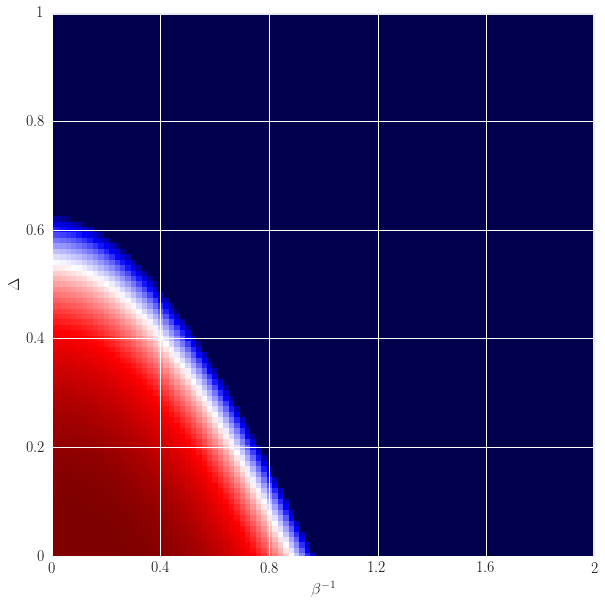

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(m, interpolation='none', cmap='seismic')
# im = ax.imshow(-0.5*(abs(m) < 1e-12), interpolation='none', cmap='seismic')
plt.xlabel(r'\beta^{-1}')
plt.ylabel(r'\Delta')
plt.xticks(list(plt.xticks()[0]),
           [-0.4, 0, 0.4, 0.8, 1.2, 1.6, 2])
plt.yticks(list(plt.yticks()[0]),
           [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlim((0,100))
plt.ylim((0,100))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# plt.savefig('hw3_2(b)2.pdf', bbox_inches='tight')